<span style="font-size: 30px;">**RAG 101 - Chat with Your Documents Using GPT & LangChain**</span>


**Objectives:** 
- *Learn how to effectively load & store documents using LangChain*
- *Build a retrieval augmented generation pipeline for querying data*
- *Build a question-answering bot that answers questions based on your documents*

You can learn more about the LangChain library in the following links:
* [How to Make Large Language Models Play Nice with Your Software Using LangChain](https://www.kdnuggets.com/how-to-make-large-language-models-play-nice-with-your-software-using-langchain)
* [6 Problems of LLMs That LangChain is Trying to Assess](https://www.kdnuggets.com/6-problems-of-llms-that-langchain-is-trying-to-assess)

Let's start by understanding our main goal:

First: 
- Take a set of PDFs. 
- Break them into pieces of texts. 
- Embed them into a vectorized representation. 
- Store them into a vector database. (FAISS, CHROMA, PINECONE...)
- Once the vectors are persistend in the ddbb, we can get queries, embed them and find a similar chunk vectors. 
- The chunks are ranked according to how relevant they are to the question and are used to contextualize our LLM. 

**IMPORTANT:** The LLM doesn't really know what PDFs have. We take advantage of the LLM model to generate NLP answers and provide it with a question and a context to generate an accurate answer. 

![Structure_main](imgs/Structure_main.png)

# Install and Import the libraries

We need to make sure our environment has the following packages: 

In [1]:
# LLM LIBRARIES
!pip install tiktoken
!pip install transformers
!pip install -U "pydantic>=2.11,<3" "pydantic-settings>=2.4,<3"
!pip install -U "langchain>=0.2,<0.4" "langchain-core>=0.2,<0.4" \
               "langchain-community>=0.2,<0.4" "langchain-pinecone>=0.2.8"

# VECTOR DATABASES
!pip install faiss-cpu
!pip install pinecone

# AUXILIAR -> Deal with PDFs and get data online
!pip install wikipedia
!pip install pypdf

# BASICS
!pip install pandas
!pip install matplotlib
!pip install python-dotenv


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.7/459.7 kB 5.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: typing-inspection
    Found existing installation: typing-inspection 0.4.1
    Uninstalling typing-inspection-0.4.1:
      Successfully uninstalled typing-inspection-0.4.1
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.33.2
    Uninstalling pydantic_core-2.33.2:
      Successfully uninstalled pydantic_core-2.33.2
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.11.9
    Uninstalling pydantic-2.11.9:
      Successfully unins

In [2]:
# Basics
import os
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# OpenAI (LLM + embeddings) — modern
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Document loaders — community package
from langchain_community.document_loaders import (
    PyPDFLoader,            # single PDF
    PyPDFDirectoryLoader,   # a folder of PDFs
    WebBaseLoader,          # optional: web pages
)

# Splitters — modern package (token-aware helpers available)
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Vector stores
from langchain_community.vectorstores import FAISS
from langchain_community.vectorstores.utils import DistanceStrategy

# Pinecone (optional: cloud vector DB)
from pinecone import Pinecone, ServerlessSpec
from langchain_pinecone import PineconeVectorStore

# Prompts & chains — modern RAG APIs
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain


/Users/josepferrersanchez/PRO/DataCamp/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
USER_AGENT environment variable not set, consider setting it to identify your requests.
/Users/josepferrersanchez/PRO/DataCamp/.venv/lib/python3.10/site-packages/langchain_pinecone/__init__.py:3: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pyda

Before starting, make sure you have avaiable: 
- OpenAI API Key
- Pinecone API Key and environment. 

In [3]:
# We can directly upload our keys using a .env
load_dotenv()

import os

openai_api_key = os.environ["OPENAI_API_KEY"]
pinecone_api_key = os.environ["PINECONE_API_KEY"]
pinecone_env_key = os.environ["PINECONE_ENV_KEY"]

# Alternatively, you can set the API keys as follows:
#OPENAI_API_KEY   = "sk-"
#PINECONE_API_KEY = "34..."
#PINECONE_ENV_KEY = "gcp-starter"


# PART 1: LANGCHAIN BASICS
Langchain is a framework that helps us create complex applications using LLMs. 

🎯 **Objective:** Understand what is the LangChain library and all the elements that are required to generate a simple pipeline to query out documents. 

### **What is LangChain?**
> LangChain is a framework for developing applications powered by language models.

LangChain makes the hardest parts of working with AI models easier in two main ways:

1. **Data-aware** - Bring external data, such as your files, other applications, and API data, to your LLMs
2. **Agentic** - Allow your LLMs to interact with it's environment via decision making. Use LLMs to help decide which action to take next. 

### **Why LangChain?**
1. **Components** - Abstractions for working with language models, along with a collection of implementations for each abstraction. Components are modular and easy-to-use, whether you are using the rest of the LangChain framework or not

2. **Chains** - LangChain provides out of the box support for using and customizing 'chains' - a series of actions strung together. A structured assembly of components for accomplishing specific higher-level tasks.

3. **Speed 🚢** - This team ships insanely fast. You'll be up to date with the latest LLM features.

4. **Community 👥** - Wonderful discord and community support, meet ups, hackathons, etc.

Though the usage of LLMs can be straightforward (text-in, text-out), when trying to build complex applications you'll quickly notice friction points. 

> LangChain helps with once you develop more complicated application and manage LLMs the way we want. 

## LangChain Components

The LangChain library contains multiple elements to ease the process of building complex applications using LangChain.
In this module we will focus mainly in 10 elements:

**To load and process our documents**
- Document Loaders
- Text Splitters
- Chat Messages *(Optional)*


**To talk with our documents using NLP**
- LLM model (GPT, Llama...)
- Chains
- Natural Language Retrieval
- Metadata and Indexes
- Memory *(Optional)*

**Both Processes**
- Text Embedding (OpenAI or Open-source models)
- Vector Stores 

![Structure_basics](imgs/Structure_basics.png)


###  **The Model - Large Language Model of our choice**
An AI-powered LLM that takes text in and responses text out. 
The default model is always ada-001, but we can explicitly choose the model of our preference. 

You can check the list of all avaialble models [here](https://platform.openai.com/docs/models)

In [4]:
# pip install -U langchain-openai
from langchain_openai import ChatOpenAI

chatgpt = ChatOpenAI(
    model="gpt-4o-mini", 
    temperature=0
    )  # or "gpt-4o"
prompt = "Please, tell me some funny jokes"
print(chatgpt.invoke(prompt).content)

Sure! Here are a few jokes to brighten your day:

1. Why don’t scientists trust atoms?
   Because they make up everything!

2. What do you call fake spaghetti?
   An impasta!

3. Why did the scarecrow win an award?
   Because he was outstanding in his field!

4. How does a penguin build its house?
   Igloos it together!

5. Why did the bicycle fall over?
   Because it was two-tired!

I hope these brought a smile to your face!


### **Chat Messages**
LangChain allows us to segmentate prompts into three main types.(System, Human, AI)

* **System** - Helpful background context that tell the AI its high-level behavior.
* **Human** - Messages that represent the user input. 
* **AI** - Messages that show the response of the AI model, they work as examples to the model. 


For more, see OpenAI's [documentation](https://platform.openai.com/docs/guides/chat/introduction)

In [5]:
# pip install -U langchain-openai
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage  # (AIMessage is returned, not sent)

chatgpt = ChatOpenAI(model="gpt-4o-mini", temperature=0)

high_level_behavior = (
    "You are an AI bot that helps people decide where to travel. "
    "Always recommend three destinations with a short sentence for each."
)

messages = [
    SystemMessage(content=high_level_behavior),
    HumanMessage(content="Where should I travel next?"),
]

response = chatgpt.invoke(messages)
print(response.content)

Here are three great travel destinations for you to consider:

1. **Kyoto, Japan** - Immerse yourself in the rich history and stunning temples of this ancient city, especially during cherry blossom season.
2. **Santorini, Greece** - Enjoy breathtaking sunsets and picturesque white-washed buildings overlooking the Aegean Sea, perfect for a romantic getaway.
3. **Machu Picchu, Peru** - Experience the awe-inspiring ruins of this Incan citadel, set high in the Andes, and hike the famous Inca Trail for an unforgettable adventure.


You can also pass more chat history with responses from the AI

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

chatgpt = ChatOpenAI(model="gpt-4o-mini", temperature=0)

messages = [
    SystemMessage(content="You are an AI bot that helps people decide where to travel. Always recommend three destinations with a short sentence for each."),
    AIMessage(content="Hello! I am a travel assistant, how can I help you?"),
    HumanMessage(content="Where should I travel next?"),
    AIMessage(content="What do you enjoy doing?"),
    HumanMessage(content="I love visiting museums."),
]

response = chatgpt.invoke(messages)
print(response.content)


Here are three fantastic destinations for museum lovers:

1. **Paris, France** - Home to the iconic Louvre and Musée d'Orsay, Paris offers a rich tapestry of art and history in its world-renowned museums.

2. **Washington, D.C., USA** - With the Smithsonian Institution's vast array of museums, including the National Gallery of Art and the National Museum of American History, there's something for everyone.

3. **Berlin, Germany** - Explore the Museum Island, a UNESCO World Heritage site, featuring five incredible museums that showcase art, archaeology, and history from various eras.


### **Text Embedding Model**

**In order to be able to process them, we can embed and convert string variables into vectors** (a series of numbers that hold the semantic 'meaning' of your text).

Mainly used when comparing different pieces of text or when dealing with huge texts. 

![Vectors_1](imgs/Vectors_1.png)

![Vectors_2](imgs/Vectors_2.png)

In [7]:
from langchain_openai import OpenAIEmbeddings  # not langchain.embeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")  # 1536-D

text = "This is an online crash course!"
vec = embeddings.embed_query(text)

print(f"Your embedding is length {len(vec)}")
print(f"Here's a sample: {vec[:5]}...")

Your embedding is length 1536
Here's a sample: [-0.0483008474111557, 0.03188679739832878, -0.029621774330735207, 0.023959221318364143, -0.026297781616449356]...


### **Chains**

Conversation chains in the context of Langchain are a concept involving the sequential linking of multiple conversational elements to build complex interactions. The idea is to streamline and enhance the conversation flow.

The most basic chain is the `ConversationChain`.

You can go check all available chains in the [LangChain Documentation.](https://python.langchain.com/docs/modules/chains/)

In [14]:
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

conversation = ConversationChain(
    llm=chatgpt, 
    memory=ConversationBufferMemory(return_messages=True))
print(conversation.invoke({"input": "Hello!"})["response"])

Hello there! How are you doing today? I'm here to chat about anything on your mind, whether it's a question, a topic of interest, or just some friendly banter. What would you like to talk about?


### Memory
When interacting with a model, it is important to keep track of all interactions performed with it. 

To overcome these limitations, langchain implements different types of memories to use in your application.

It is important to consider that storing all the interactions with the model can quickly escalate to a considerable amount of tokens to process every time we prompt the model. It is essential to bear in mind that ChatGPT has a token limit per interaction.

You can learn more about memory [here]([https://towardsdatascience.com/custom-memory-for-chatgpt-api-artificial-intelligence-python-722d627d4d6d])



In [15]:
from langchain_openai import ChatOpenAI
from langchain.memory import ConversationSummaryBufferMemory
from langchain.chains import ConversationChain

chatgpt = ChatOpenAI(model="gpt-4o-mini", temperature=0)   # main chat model
memory = ConversationSummaryBufferMemory(llm=chatgpt, max_token_limit=100)  # summarizer uses same model

# seed some context
memory.save_context({"input": "Can you recommend where I should travel next?"},
                    {"output": "Sure! What do you enjoy doing?"})
memory.save_context({"input": "I love visiting museums."},
                    {"output": "Great—cultural capitals could be perfect."})

conversation = ConversationChain(llm=chatgpt, memory=memory, verbose=True)
resp = conversation.invoke({"input": "What cities do you recommend?"})
print(resp["response"])



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Can you recommend where I should travel next?
AI: Sure! What do you enjoy doing?
Human: I love visiting museums.
AI: Great—cultural capitals could be perfect.
Human: What cities do you recommend?
AI:

> Finished chain.
There are several fantastic cities known for their museums! Here are a few recommendations:

1. **Paris, France**: Home to the Louvre, which is the world's largest art museum, and the Musée d'Orsay, known for its impressive collection of Impressionist and Post-Impressionist masterpieces. Don't forget the Centre Pompidou for modern art!

2. **New York City, USA**: The Metropolitan Museum of Art is a must-visit, along with the Museum of Modern Art (

In [16]:
print(memory.moving_summary_buffer)

The human asks the AI for travel recommendations, expressing a love for visiting museums. The AI suggests that cultural capitals would be perfect and lists several cities known for their museums, including Paris, New York City, Rome, London, Berlin, and Amsterdam, highlighting key museums in each city. The AI then asks if any of these cities resonate with the human.


### Dealing with Documents

We are here to deal with documents... so LangChain provides a wide variety of elements to deal with them. 

One of the most important improvements of LangChain is that it allows us to upload documents and pass them to our model. 
We consider a document as an object that holds a piece of text and metadata (more information about that text)

- Document class
- Document Loader
- Document Retriever
- Text Splitter
- Index

In [17]:
from langchain_core.documents import Document  # modern import

doc = Document(
    page_content="This is a dummy document",
    metadata={"id": "677", "source": 
              "mysource.pdf", 
              "created_at": "2022-06-01"}
)

print(doc)

page_content='This is a dummy document' metadata={'id': '677', 'source': 'mysource.pdf', 'created_at': '2022-06-01'}


#### Document Loaders

Depending on where our data is stored, we will need a different type of loader:

- The **Online Loader** is used for loading a document directly from the Internet. LangChain implements different types of loaders. For example, there is the `WikipediaLoader` that helps you loading Wikipedia pages or the `HNLoader` to take content directly from any HackerNews page.



- The **Offline Loader** is used loading a document stored that are already installed in your machine. There are also different types of offline loaders such as the **HTML** loader for `.html` pages or the **PyPDFLoader** for `.pdf` documents.

In this tutorial, we will see an example of Online Loader by using the `WikipediaLoader` and the `HNLoader`, and an example of Offline Loader by using the PyPDFLoader.

You can find a list of the supported [LangChain Document Loaders](https://python.langchain.com/docs/integrations/document_loaders) in the official documentation. Those Loaders are from external integrations, [native LangChain Loaders](https://python.langchain.com/docs/modules/data_connection/document_loaders/) can be found in the official documentation as well.

In [18]:
# pip install wikipedia langchain-community
from langchain_community.document_loaders import WikipediaLoader

loader = WikipediaLoader(query="Machine learning", lang="en", load_max_docs=1, doc_content_chars_max=4000)
wikipedia_data = loader.load()  # It returns a list of loaders

print(wikipedia_data[0])  # a Document with .page_content and .metadata (e.g., source URL)

page_content='Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML finds application in many fields, including natural language processing, computer vision, speech recognition, email filtering, agriculture, and medicine. The application of ML to business problems is known as predictive analytics.
Statistics and mathematical optimisation (mathematical programming) methods comprise the foundations of machine learning. Data mining is a related field of study, focusing on exploratory data analysis (EDA) via unsupervised learning.
From a theoretical viewpoint, probably approximately co

In [19]:
print("\nPage Content: \n", wikipedia_data[0].page_content)
print("\nMeta Data: \n", wikipedia_data[0].metadata)


Page Content: 
 Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML finds application in many fields, including natural language processing, computer vision, speech recognition, email filtering, agriculture, and medicine. The application of ML to business problems is known as predictive analytics.
Statistics and mathematical optimisation (mathematical programming) methods comprise the foundations of machine learning. Data mining is a related field of study, focusing on exploratory data analysis (EDA) via unsupervised learning.
From a theoretical viewpoint, probably approximately

Now we will repeat the previous procedure using `WebBaseLoader` and `PyPDFLoader`. 


In [20]:
# pip install -U langchain-community pypdf beautifulsoup4
from langchain_community.document_loaders import WebBaseLoader, PyPDFLoader, PyPDFDirectoryLoader

# HN page
hn_loader = WebBaseLoader("https://www.cnbc.com/2025/09/05/openai-is-building-an-ai-jobs-platform-that-could-rival-microsofts-linkedin.html")
hn_data = hn_loader.load()  # list[Document]

# Single PDF
pdf_loader = PyPDFLoader("docs/attentions.pdf")
pdf_data = pdf_loader.load()

# Multiple PDFs (optional)
# dir_loader = PyPDFDirectoryLoader("../docs")
# pdf_directory_data = dir_loader.load()

In [21]:
print("\nPage Content: \n", hn_data[0].page_content)
print("\nMeta Data: \n", hn_data[0].metadata)


Page Content: 
 OpenAI is building an AI jobs platform that could challenge Microsoft’s LinkedInSkip NavigationMarketsPre-MarketsU.S. MarketsEurope MarketsChina MarketsAsia MarketsWorld MarketsCurrenciesCryptocurrencyFutures & CommoditiesBondsFunds & ETFsBusinessEconomyFinanceHealth & ScienceMediaReal EstateEnergyClimateTransportationIndustrialsRetailWealthSportsLifeSmall BusinessInvestingPersonal FinanceFintechFinancial AdvisorsOptions ActionETF StreetBuffett ArchiveEarningsTrader TalkTechCybersecurityAIEnterpriseInternetMediaMobileSocial MediaCNBC Disruptor 50Tech GuidePoliticsWhite HousePolicyDefenseCongressExpanding OpportunityEurope PoliticsChina PoliticsAsia PoliticsWorld PoliticsVideoLatest VideoFull EpisodesLivestreamTop VideoLive AudioEurope TVAsia TVCNBC PodcastsCEO InterviewsDigital OriginalsWatchlistInvesting ClubTrust PortfolioAnalysisTrade AlertsMeeting VideosHomestretchJim's ColumnsEducationSubscribePROPro NewsJosh BrownNEW!LivestreamFull EpisodesStock ScreenerMarket Fo

In [22]:
print("\nPage Content: \n", pdf_data[0].page_content)
print("\nMeta Data: \n", pdf_data[0].metadata)


Page Content: 
 Provided proper attribution is provided, Google hereby grants permission to
reproduce the tables and figures in this paper solely for use in journalistic or
scholarly works.
Attention Is All You Need
Ashish Vaswani∗
Google Brain
avaswani@google.com
Noam Shazeer∗
Google Brain
noam@google.com
Niki Parmar∗
Google Research
nikip@google.com
Jakob Uszkoreit∗
Google Research
usz@google.com
Llion Jones∗
Google Research
llion@google.com
Aidan N. Gomez∗ †
University of Toronto
aidan@cs.toronto.edu
Łukasz Kaiser∗
Google Brain
lukaszkaiser@google.com
Illia Polosukhin∗ ‡
illia.polosukhin@gmail.com
Abstract
The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks that include an encoder and a decoder. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer,
based solely on attention mechanisms, dispensing with recurrence and convoluti

#### Text Splitter


*Why we split at all*

LLMs and embedding models have context limits; you can’t shove whole PDFs in.

Smaller pieces (“chunks”) make retrieval more precise: you fetch only the relevant bits instead of whole pages.

**Data Chunks and Model Tokenizer**

##### Data Chunks (token-aware)
To make documents usable by an LLM, we split them into smaller chunks. Chunk size strongly affects retrieval quality and cost.

##### Tokenizer vs. embeddings
A tokenizer converts text to tokens so models can process it, but we usually don’t manipulate tokens directly. Instead, we use a token-aware splitter so chunks align with model limits. The vector store then saves each chunk’s embedding vector (plus the original text/metadata)—not tokens.

By using Langchain, we can highly customize how to split our data:
- **Split by chunks**: The most general approach is to split your data into chunks of a concrete size. In the following example, we will take the data that we have already loaded (`wikipedia_data`, `hn_data` and `pdf_data`) and we will split it in portions of 200 characters. 

_What will happen if the split based on character count breaks a word?_

There is the concept of "chunk overlap" that refers to a method where consecutive chunks of text share some common content. This technique is used to maintain context and coherence when a long document is divided into smaller parts due to the token limitations of LLMs. In this case, we will use a chunk size of 20 characters.

So let's split the Wikipedia data we have just loaded: 

In [23]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name="cl100k_base",   # good default for GPT-3.5/4 families
    chunk_size=200,
    chunk_overlap=20,
)

wikipedia_chunks = text_splitter.split_documents(wikipedia_data)  # list[Document]
print(f"Wikipedia Data - Now you have {len(wikipedia_chunks)} chunks.")


Wikipedia Data - Now you have 7 chunks.


Now we will replicate exactly the same for both `WebBaseLoader` and `PyPDFLoader`. 

In [24]:
# pip install -U langchain-text-splitters tiktoken
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Use OpenAI-compatible tokenization (no custom length_function needed)
pdf_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name="cl100k_base", chunk_size=200, chunk_overlap=20
)
hn_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name="cl100k_base", chunk_size=200, chunk_overlap=20
)

pdf_chunks = pdf_splitter.split_documents(pdf_data)  # pdf_data: list[Document]
print(f"PDF Data - Now you have {len(pdf_chunks)} chunks.")

hn_chunks = hn_splitter.split_documents(hn_data)    # hn_data: list[Document]
print(f"Online HN - Now you have {len(hn_chunks)} chunks.")


PDF Data - Now you have 62 chunks.
Online HN - Now you have 9 chunks.


We can make sure that the chunking has been successful by visualizing the distribution of chunk sizes. 
Since we have selected a chunk size of 200, the majority of our chunks should have this lenght:

count     62.000000
mean     168.580645
std       39.967425
min       24.000000
50%      183.000000
90%      194.000000
95%      196.000000
max      199.000000
Name: token_count, dtype: float64


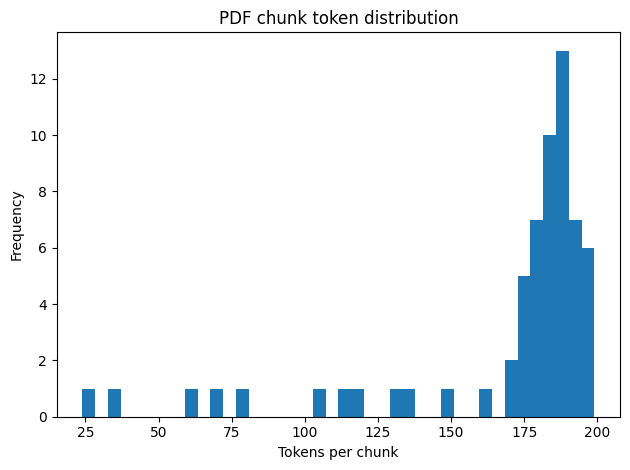

In [25]:
# pip install tiktoken pandas matplotlib
import tiktoken
import pandas as pd
import matplotlib.pyplot as plt

# 1) Token counter (OpenAI models)
enc = tiktoken.get_encoding("cl100k_base")
def count_tokens(text: str) -> int:
    return len(enc.encode(text or "", disallowed_special=()))

# 2) Count tokens per chunk
token_counts = [count_tokens(doc.page_content) for doc in pdf_chunks]  # pdf_chunks: list[Document]

# 3) Quick look: stats + histogram
df = pd.DataFrame({"token_count": token_counts})
print(df["token_count"].describe(percentiles=[0.5, 0.9, 0.95]))

plt.figure()
plt.hist(df["token_count"], bins=40)
plt.xlabel("Tokens per chunk")
plt.ylabel("Frequency")
plt.title("PDF chunk token distribution")
plt.tight_layout()
plt.show()

- **Split by pages**: If your data comes from documents organized in pages, there are methods that allow you to split data in pages to keep track of the page content. This method is specially useful when dealing with PDFs, as in the following example:

In [26]:
# pip install -U langchain-community pypdf
from langchain_community.document_loaders import PyPDFLoader

# A) Truly split by pages (recommended given your print message)
loader = PyPDFLoader("docs/attentions.pdf")
pdf_pages = loader.load()  # one Document per page

print("\nSPLITTING BY PAGES")
print(f"PDF split by pages — you have {len(pdf_pages)} chunks.")


SPLITTING BY PAGES
PDF split by pages — you have 15 chunks.


### Vector Stores

Vector stores, also known as vector databases, are specialized types of databases designed to efficiently handle and manipulate high-dimensional vector data. In our case, we will store the tokenized and splitted content, e.g., the data chunks in the format that LLMs can process.

There are different types of vector stores. Depending on the storage of the data, we can classify them as:
- **Local Vector Stores**: This type of databases store the information in your local system. As an example of Local Vector Store, we will use FAISS.
- **Online Vector Stores**: This type of databases store the information in the cloud. We will use Pinecone as out preferred option for Online Vector Stores.

FAISS - EXAMPLE OF LOCAL VECTOR STORE

In [27]:
from langchain.vectorstores import FAISS  # for the vector database part -- FAISS is local and temporal, Pinecone is cloud-
from langchain.embeddings.openai import OpenAIEmbeddings

# Get embedding model
embeddings = OpenAIEmbeddings()

# OPTION 1: FAISS (Facebook AI Similarity Search) Local _______________________________________________________________________________________
# Create vector database
db_FAISS = FAISS.from_documents(pdf_chunks, embeddings)

/var/folders/5h/h364vcws335c872gj8pv3jvm0000gn/T/ipykernel_2804/2279994550.py:5: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings()


PINECONE - EXAMPLE OF ONLINE VECTOR STORE

In [28]:
# pip install -U pinecone langchain-pinecone
import os
from pinecone import Pinecone, ServerlessSpec
from langchain_pinecone import PineconeVectorStore

pc = Pinecone(api_key=os.environ["PINECONE_API_KEY"])

index_name = "datacamp-rag-tutorial"

if index_name not in [i.name for i in pc.list_indexes()]:
    pc.create_index(
        name=index_name,
        dimension=1536,                 # match your embeddings model (e.g., OpenAI text-embedding-3-small = 1536)
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")  # pick your region
    )

# Build / upsert with LangChain
db_Pinecone = PineconeVectorStore.from_documents(
    documents=pdf_chunks,              # your list[Document]
    embedding=embeddings,              # your embeddings object
    index_name=index_name,
)

### Natural Language Retrieval
We first start performing a semantic search within our Vector DataBase. 

In [29]:
from langchain_community.vectorstores import FAISS

db = FAISS.from_documents(pdf_chunks, embeddings)  # pdf_chunks: list[Document]
matches = db.similarity_search("List all authors of 'Attention Is All You Need'", k=2)

In [30]:
print(matches[0])

page_content='Provided proper attribution is provided, Google hereby grants permission to
reproduce the tables and figures in this paper solely for use in journalistic or
scholarly works.
Attention Is All You Need
Ashish Vaswani∗
Google Brain
avaswani@google.com
Noam Shazeer∗
Google Brain
noam@google.com
Niki Parmar∗
Google Research
nikip@google.com
Jakob Uszkoreit∗
Google Research
usz@google.com
Llion Jones∗
Google Research
llion@google.com
Aidan N. Gomez∗ †
University of Toronto
aidan@cs.toronto.edu
Łukasz Kaiser∗
Google Brain
lukaszkaiser@google.com
Illia Polosukhin∗ ‡
illia.polosukhin@gmail.com
Abstract' metadata={'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'creationdate': '2023-08-03T00:07:29+00:00', 'author': '', 'keywords': '', 'moddate': '2023-08-03T00:07:29+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'subject': '', 'title': '', 'trapped': '/False', 'source': 'docs/attentions.pdf', 'tot

In [31]:
print(matches[1])

page_content='<EOS>
<pad>
The
Law
will
never
be
perfect
,
but
its
application
should
be
just
-
this
is
what
we
are
missing
,
in
my
opinion
.
<EOS>
<pad>
Figure 4: Two attention heads, also in layer 5 of 6, apparently involved in anaphora resolution. Top:
Full attentions for head 5. Bottom: Isolated attentions from just the word ‘its’ for attention heads 5
and 6. Note that the attentions are very sharp for this word.
14' metadata={'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'creationdate': '2023-08-03T00:07:29+00:00', 'author': '', 'keywords': '', 'moddate': '2023-08-03T00:07:29+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'subject': '', 'title': '', 'trapped': '/False', 'source': 'docs/attentions.pdf', 'total_pages': 15, 'page': 13, 'page_label': '14', 'text': '<EOS>\n<pad>\nThe\nLaw\nwill\nnever\nbe\nperfect\n,\nbut\nits\napplication\nshould\nbe\njust\n-\nthis\nis\nwhat\nwe\nare\nmissing\n,\nin

In the above section, we have seen how to retrieve the coincidences of you query in the documents in our vector store. Nevertheless, the output is a bit difficult to read. We can leverage the usage of LLMs by feeding the coincidences in our vector store to an LLM and let it generate a response in Natural Language using the additional information from our documents. We can do so by using the so-called **[LangChain Chains](https://python.langchain.com/docs/expression_language/get_started)**.

In [32]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain

# 1- WE DEFINE OUR QUERY
query = "List all authors of the paper 'Attention Is All You Need'."

# 2- WE PERFORM A SEMANTIC SEARCH IN OUR VECTOR DATABASE
matches = db_Pinecone.similarity_search(query, k=2)

# 3 - WE GENERATE A RAG PIPELINE BY SENDING THESE MATCHES TO AN LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
prompt = ChatPromptTemplate.from_template(
    "Use ONLY the context to answer. If not in context, say you don't know.\n\n{context}\n\nQuestion: {input}"
)
doc_chain = create_stuff_documents_chain(llm, prompt)
retriever = db_Pinecone.as_retriever(search_type="similarity", k=4)  # or search_type="mmr"
rag = create_retrieval_chain(retriever, doc_chain)

# 4 - WE INVOKE THE RETRIEVER
resp = rag.invoke({"input": query})
print(resp["answer"])

The authors of the paper "Attention Is All You Need" are:

1. Ashish Vaswani
2. Noam Shazeer
3. Niki Parmar
4. Jakob Uszkoreit
5. Llion Jones
6. Aidan N. Gomez
7. Łukasz Kaiser
8. Illia Polosukhin


Now we can replicate the same using `FAISS`.

In [33]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain_community.vectorstores import FAISS

# 1- WE DEFINE OUR QUERY
query = "List all authors of the paper 'Attention Is All You Need'."

# 2- WE PERFORM A SEMANTIC SEARCH IN OUR VECTOR DATABASE
db = FAISS.from_documents(pdf_chunks, embeddings)
retriever = db.as_retriever(search_type="similarity", k=2)

# LLM + prompt
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
prompt = ChatPromptTemplate.from_template(
    "Use the context to answer the question.\n\n{context}\n\nQuestion: {input}"
)
# 3 - WE GENERATE A RAG PIPELINE BY SENDING THESE MATCHES TO AN LLM
doc_chain = create_stuff_documents_chain(llm, prompt)
rag = create_retrieval_chain(retriever, doc_chain)

# 4 - WE INVOKE THE RETRIEVER
resp = rag.invoke({"input": query})
print(resp["answer"])              # final answer
# print(resp["context"])           # the retrieved Documents (optional)

The authors of the paper "Attention Is All You Need" are:

1. Ashish Vaswani
2. Noam Shazeer
3. Niki Parmar
4. Jakob Uszkoreit
5. Llion Jones
6. Aidan N. Gomez
7. Łukasz Kaiser
8. Illia Polosukhin


### Indexes and Metadata
When we upload data to our vector database, there is metadata that allows us to understand where the data is coming from. 
When dealing with PDFs, the source information allows us to know what pdf and page the info is coming from.

In [34]:
#from langchain.embeddings import OpenAIEmbeddings
#from langchain.indexes import index

query = "Who created transformers?"
matches = db_FAISS.similarity_search(query)

print("______________________________________ THIRD MATCH")

print("We can get the chunk text content and get: \n", matches[3].page_content)
print("\nWe can get the chunk metadata and get: \n", matches[3].metadata)
print("\nThe source of our match is: \n" , matches[3].metadata["source"], "and page", matches[3].metadata["page"])

______________________________________ THIRD MATCH
We can get the chunk text content and get: 
 significant improvements in computational efficiency through factorization tricks [21] and conditional
computation [32], while also improving model performance in case of the latter. The fundamental
constraint of sequential computation, however, remains.
Attention mechanisms have become an integral part of compelling sequence modeling and transduc-
tion models in various tasks, allowing modeling of dependencies without regard to their distance in
the input or output sequences [2, 19]. In all but a few cases [27], however, such attention mechanisms
are used in conjunction with a recurrent network.
In this work we propose the Transformer, a model architecture eschewing recurrence and instead
relying entirely on an attention mechanism to draw global dependencies between input and output.
The Transformer allows for significantly more parallelization and can reach a new state of the art in
transl

Now it is the time to put it all together and generate a simple pipeline to query our documents using a LLM model. 

In [35]:
from pathlib import Path
from langchain_core.documents import Document

def ensure_meta(doc: Document) -> Document:
    m = doc.metadata
    # guarantee keys exist and are JSON-safe
    m["source"] = str(m.get("source") or m.get("file_path") or m.get("url") or "unknown")
    m["page"] = m.get("page", "N/A")
    # optional: prebuilt citation for prompts / UI
    page_disp = (m["page"] + 1) if isinstance(m["page"], int) else m["page"]
    m["citation"] = f"{Path(m['source']).name} • p.{page_disp}"
    doc.metadata = m
    return doc

# PART 2: Loading and processing our documents



PyPDFDirectoryLoader allows us to upload multiple PDFs at once. In our case, we have two PDFs in the Docs directory.

## **STEP 1 - LOADER**

Use the `PDFDirectoryLoader` to upload all PDFs contained within the the Docs folder. 

In [36]:
#STEP 1 - LOADER
from langchain_community.document_loaders import PyPDFDirectoryLoader

loader = PyPDFDirectoryLoader("docs")
pdf_pages = loader.load()                         # list[Document], one per page
pdf_pages = [ensure_meta(d) for d in pdf_pages]
print(f"Loaded {len(pdf_pages)} page-docs from docs")


Loaded 101 page-docs from docs


## **STEP 2 - CHUNKING**

Generate the chunks for the PDFs contained in the directory. 
1. Import both RecursiveCharacterTextSplitter from langchain.text_splitter and GPT2TokenizerFast from transformers. 
2. Define a tokenizer with the following command: tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
3. Define a count_tokens function that will allow us to count the tokens of out text. 
4. Define the text_splitter with a chunk_size of 200, a chunk_overlap of 20 and the length_function we have just defined. 
5. Apply the command `.split_documents`to our data. 

In [37]:
#STEP 2 - CHUNKING OUR DATA
from langchain_text_splitters import RecursiveCharacterTextSplitter
splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name="cl100k_base", chunk_size=200, chunk_overlap=20
)
pdf_chunks = splitter.split_documents(pdf_pages)
pdf_chunks = [ensure_meta(d) for d in pdf_chunks]   # <- this is the list you'll embed
print(f"Loaded {len(pdf_pages)} page-docs; produced {len(pdf_chunks)} chunks.")

Loaded 101 page-docs; produced 584 chunks.


## **STEP 3 - EMBEDD AND UPLOAD THE DATA INTO A VECTORSTORE**

**TASK**
- Upload the data into the FAISS vector store using the `from_documents`command. 

In [38]:
# STEP 3 - EMBEDDING AND UPLOAD DATA INTO OUR VECTORSTORE

# ___________________________________________________________________________ LOCAL VERSION
from langchain_community.vectorstores import FAISS
from langchain_community.vectorstores.utils import DistanceStrategy

# Build local FAISS index
db_FAISS = FAISS.from_documents(
    documents=pdf_chunks,
    embedding=embeddings,                         # e.g., OpenAIEmbeddings("text-embedding-3-small")
    distance_strategy=DistanceStrategy.COSINE,
)

# Quick check
query = "Who created Transformers?"

matches = db_FAISS.similarity_search(query, k=3)
print(f"We found {len(matches)} similarities.")
for i, m in enumerate(matches, 1):
    print(f"\n[{i}] {m.metadata.get('citation', m.metadata)}")
    print(m.page_content[:300], "...")

We found 3 similarities.

[1] codex.pdf • p.16
training of deep bidirectional transformers for language under-
standing. arXiv preprint arXiv:1810.04805, 2018.
Dhariwal, P., Jun, H., Payne, C., Kim, J. W., Radford, A., and
Sutskever, I. Jukebox: A generative model for music. arXiv
preprint arXiv:2005.00341, 2020.
Drain, D., Wu, C., Svyatkovskiy, ...

[2] attentions.pdf • p.1
training for 3.5 days on eight GPUs, a small fraction of the training costs of the
best models from the literature. We show that the Transformer generalizes well to
other tasks by applying it successfully to English constituency parsing both with
large and limited training data.
∗Equal contribution. ...

[3] codegen.pdf • p.9
to natural language processing (Devlin et al., 2019; Lewis et al., 2020; Raffel et al., 2020), computer
vision (Dosovitskiy et al., 2021), and many other areas (Oord et al., 2018; Jumper et al., 2021). Prior
works, such as CuBERT (Kanade et al., 2020), CodeBERT (Feng et al., 2020), PyMT5 (Clem

# PART 3: Talking with our documents

## STEP 4 - DEFINE A CHAIN AND PERFORM THE SIMILARITY SEARCH
Generating a simple pipeline to query our documents with a load_qa_chain. 

In [39]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain_community.vectorstores import FAISS

# Vector store & retriever
db = FAISS.from_documents(pdf_chunks, embeddings)
retriever = db.as_retriever(search_type="similarity", k=2)

# LLM + prompt
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
prompt = ChatPromptTemplate.from_template(
    "Use the context to answer the question.\n\n{context}\n\nQuestion: {input}"
)

# Build chains
doc_chain = create_stuff_documents_chain(llm, prompt)
rag = create_retrieval_chain(retriever, doc_chain)

# Ask
q = "List all the authors of the paper 'Attention Is All You Need'."
resp = rag.invoke({"input": q})
print(resp["answer"])              # final answer
# print(resp["context"])           # the retrieved Documents (optional)

The authors of the paper "Attention Is All You Need" are:

1. Ashish Vaswani
2. Noam Shazeer
3. Niki Parmar
4. Jakob Uszkoreit
5. Llion Jones
6. Aidan N. Gomez
7. Łukasz Kaiser
8. Illia Polosukhin


Now that we already have a working pipeline to query our documents, we want to understand where our data is coming from. 

In [40]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain_community.vectorstores import FAISS

# Vector store & retriever
db = FAISS.from_documents(pdf_chunks, embeddings)
retriever = db.as_retriever(search_type="similarity", k=2)

# LLM + prompt
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
prompt = ChatPromptTemplate.from_template(
    "Use the context to answer the question.\n\n{context}\n\nQuestion: {input}. Please state info sources (both pdf and page of the pdf found in the beginning of each chunk) in the response"
)

# Build chains
doc_chain = create_stuff_documents_chain(llm, prompt)
rag = create_retrieval_chain(retriever, doc_chain)

# Ask
q = "List all the authors of the paper 'Attention Is All You Need'."
resp = rag.invoke({"input": q})
print(resp["answer"])              # final answer
# print(resp["context"])           # the retrieved Documents (optional)

The authors of the paper "Attention Is All You Need" are:

1. Ashish Vaswani
2. Noam Shazeer
3. Niki Parmar
4. Jakob Uszkoreit
5. Llion Jones
6. Aidan N. Gomez
7. Łukasz Kaiser
8. Illia Polosukhin

**Info Sources:**
- PDF: The information is found in the provided citation and author list at the beginning of the document.
- Page: The authors are listed on page 1747 of the document (as indicated in the citation).


Try to ask the model something that is completely out of scope, and see what happens!

In [41]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain_community.vectorstores import FAISS

# Vector store & retriever
db = FAISS.from_documents(pdf_chunks, embeddings)
retriever = db.as_retriever(search_type="similarity", k=2)

# LLM + prompt
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
prompt = ChatPromptTemplate.from_template(
    "Use the context to answer the question.\n\n{context}\n\nQuestion: {input}"
)

# Build chains
doc_chain = create_stuff_documents_chain(llm, prompt)
rag = create_retrieval_chain(retriever, doc_chain)

# Ask
q = "What are the main problems to cook with olive oil?"
resp = rag.invoke({"input": q})
print(resp["answer"])              # final answer
# print(resp["context"])           # the retrieved Documents (optional)

The provided context does not directly address the problems associated with cooking with olive oil. However, based on general knowledge, some common issues when cooking with olive oil include:

1. **Smoke Point**: Olive oil has a lower smoke point compared to some other oils, which means it can start to smoke and break down at lower temperatures. This can affect the flavor of the food and produce harmful compounds.

2. **Flavor**: The distinct flavor of olive oil may not be suitable for all dishes, especially those that require a neutral oil.

3. **Nutrient Loss**: Cooking at high temperatures can lead to the degradation of some of the beneficial compounds in olive oil, such as antioxidants.

4. **Cost**: High-quality extra virgin olive oil can be more expensive than other cooking oils, which may be a consideration for some cooks.

5. **Storage**: Olive oil can go rancid if not stored properly, which can affect its taste and health benefits.

If you need more specific information or ha

Try other queries and talk with your documents!

In [42]:
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain

def asking_your_model(query: str, k: int = 3) -> str:
    # 1) Retriever from your FAISS index
    retriever = db_FAISS.as_retriever(
        search_type="mmr", 
        search_kwargs={"k": k, "fetch_k": max(12, 3*k)}
    )

    # 2) Metadata-aware prompts
    doc_prompt = PromptTemplate.from_template(
        "SOURCE: {metadata[source]} | PAGE: {metadata[page]}\nCONTENT:\n{page_content}"
    )
    chat_prompt = ChatPromptTemplate.from_template(
        "Use ONLY the context below to answer. If it's not in the context, say you don't know.\n"
        "After the answer, add a line 'Sources:' listing every SOURCE and PAGE you used.\n\n"
        "{context}\n\nQuestion: {input}"
    )

    # 3) Build RAG chain with your existing ChatOpenAI instance `chatgpt`
    doc_chain = create_stuff_documents_chain(chatgpt, chat_prompt, document_prompt=doc_prompt)
    rag = create_retrieval_chain(retriever, doc_chain)

    # 4) Ask
    resp = rag.invoke({"input": query})
    return resp["answer"]

In [43]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain

def ask(query: str, k: int = 2, db=None, model: str = "gpt-4o-mini") -> str:
    if db is None:
        raise ValueError("Pass a FAISS `db` (vector store) built from your chunks.")

    retriever = db.as_retriever(search_type="similarity", k=k)
    llm = ChatOpenAI(model=model, temperature=0)

    prompt = ChatPromptTemplate.from_template(
        "Use the context below to answer the question succinctly and accurately.\n\n{context}\n\nQuestion: {input}"
    )

    doc_chain = create_stuff_documents_chain(llm, prompt)  # uses doc.page_content only
    rag = create_retrieval_chain(retriever, doc_chain)

    resp = rag.invoke({"input": query})
    return resp["answer"]

In [44]:
# Check similarity search is working
query = "What is functional correctness?"
response = ask(query, k=4, db=db_FAISS)
print(response)

Functional correctness refers to the evaluation of a program based on its ability to pass a set of predefined unit tests, ensuring that it behaves as intended according to specified requirements. This metric is used to assess the correctness of code generation, particularly in contexts like unsupervised code translation and docstring-conditional code generation, as it aligns with how human developers judge code quality.


In [45]:
# Check similarity search is working
query = "What is the multi-head attention in a transformer?"
response = ask(query, k=4, db=db_FAISS)
print(response)

Multi-head attention in a Transformer is a mechanism that allows the model to jointly attend to information from different representation subspaces at various positions. It consists of multiple parallel attention layers, or heads, which process the input data simultaneously. Each head computes attention using its own set of learned projections for queries, keys, and values, enabling the model to capture diverse features and relationships in the data. The outputs from all heads are concatenated and projected to form the final values, enhancing the model's ability to understand complex dependencies in the input and output sequences.


In [46]:
# Check similarity search is working
query = "What are the main components of a transformer?"
response = ask(query, k=4, db=db_FAISS)
print(response)

The main components of a Transformer are:

1. **Encoder**: Composed of a stack of identical layers (N = 6), each with:
   - Multi-head self-attention mechanism
   - Position-wise fully connected feed-forward network
   - Residual connections and layer normalization around each sub-layer

2. **Decoder**: Similar to the encoder, it also consists of stacked layers with self-attention and feed-forward networks, but includes mechanisms to attend to the encoder's output.

3. **Attention Mechanism**: Allows modeling of dependencies between input and output sequences without regard to their distance.

4. **Residual Connections and Layer Normalization**: Enhance training stability and performance.

These components work together to enable parallelization and improve translation quality.
